In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Constants
DATA_DIRECTORY = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'

Epoch 1/10
----------
train Loss: 2.1859 Acc: 0.2588
validation Loss: 1.6089 Acc: 0.4173
Epoch 2/10
----------
train Loss: 1.6165 Acc: 0.4296
validation Loss: 1.1907 Acc: 0.5670
Epoch 3/10
----------
train Loss: 1.3045 Acc: 0.5595
validation Loss: 0.9840 Acc: 0.6817
Epoch 4/10
----------
train Loss: 1.0603 Acc: 0.6479
validation Loss: 0.7630 Acc: 0.7250
Epoch 5/10
----------
train Loss: 0.8855 Acc: 0.7154
validation Loss: 0.7900 Acc: 0.7383
Epoch 6/10
----------
train Loss: 0.7609 Acc: 0.7546
validation Loss: 0.4913 Acc: 0.8400
Epoch 7/10
----------
train Loss: 0.6578 Acc: 0.7903
validation Loss: 1.0984 Acc: 0.7540
Epoch 8/10
----------
train Loss: 0.6107 Acc: 0.8107
validation Loss: 0.4891 Acc: 0.8337
Epoch 9/10
----------
train Loss: 0.5369 Acc: 0.8373
validation Loss: 0.3561 Acc: 0.8917
Epoch 10/10
----------
train Loss: 0.4688 Acc: 0.8590
validation Loss: 0.5605 Acc: 0.8407
Best validation Acc: 0.891667


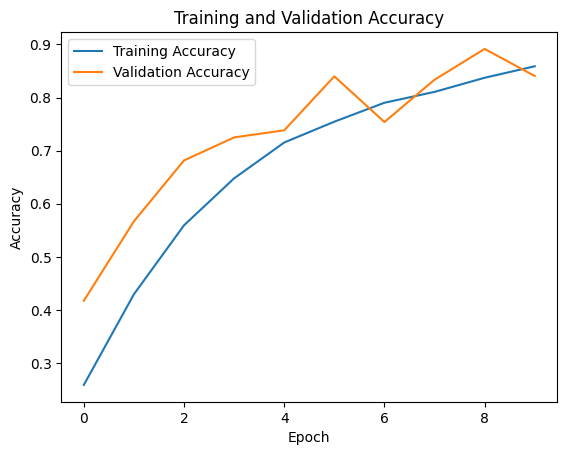

Test Accuracy: 0.8597
Precision: 0.8857
Recall: 0.8597
F1 Score: 0.8608
Mean Loss: 0.5217
              precision    recall  f1-score   support

        Bean       0.74      0.68      0.71       200
Bitter_Gourd       0.56      0.95      0.70       200
Bottle_Gourd       0.98      0.85      0.91       200
     Brinjal       0.77      0.89      0.83       200
    Broccoli       0.81      0.94      0.87       200
     Cabbage       0.87      0.86      0.86       200
    Capsicum       0.98      0.94      0.96       200
      Carrot       0.99      0.97      0.98       200
 Cauliflower       0.93      0.85      0.89       200
    Cucumber       0.97      0.56      0.72       200
      Papaya       0.98      0.63      0.77       200
      Potato       0.99      0.98      0.99       200
     Pumpkin       0.76      0.98      0.86       200
      Radish       1.00      0.93      0.96       200
      Tomato       0.94      0.89      0.91       200

    accuracy                           0.86 

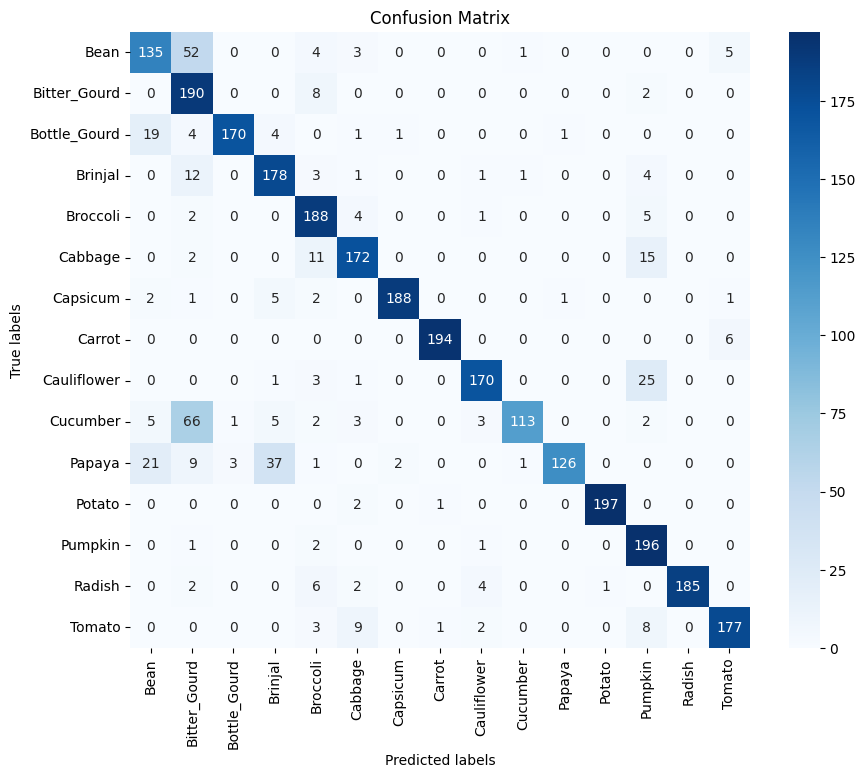

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    num_output_classes = len(image_datasets['train'].classes)
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)
    )
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        if val_acc_history[-1] > best_acc:
            best_acc = val_acc_history[-1]

    print('Best validation Acc: {:4f}'.format(best_acc))

    plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    print(classification_report(y_true, y_pred, target_names=image_datasets['test'].classes))

    return y_true, y_pred

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, criterion, optimizer, num_epochs=10)

y_true, y_pred = evaluate_model(model, dataloaders['test'])

conf_matrix = confusion_matrix(y_true, y_pred)
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)